# Emergence of compositional concepts from reference games with raw pixel input

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split

random = np.random.RandomState()

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

In [2]:
def load_continuous_messages(filepath, proj='pca', return_orig=False):
    """
    Preprocess continuous messages. Does PCA reduction to two dimensions.
    """
    npzs = np.load(filepath)
    npzs = {x: npzs[x] for x in npzs.files}

    if proj == 'pca':
        msgs_proj = PCA(2).fit_transform(npzs['msgs'])
    elif proj == 'tsne':
        msgs_proj = TSNE(2).fit_transform(npzs['msgs'])
    else:
        raise ValueError("Unknown projection {}".format(proj))
    
    msgs = pd.DataFrame({
        'x': msgs_proj[:, 1],
        'y': msgs_proj[:, 0],
        'correct': np.all(npzs['preds'] == npzs['obs'], axis=1),
        'relation_dir': npzs['relation_dirs'],
        'relation': npzs['relations'],
        'relation_pair': pd.Series(list(zip(npzs['relation_dirs'], npzs['relations'])))
    })
    if return_orig:
        return msgs, npzs
    else:
        return msgs

def plot2d(msgs, hue='relation_pair'):
    """Plot PCA-reduced messages, colored by relation or other factor"""
    sns.lmplot('x', 'y', data=msgs, fit_reg=False, hue=hue, legend_out=True,
           scatter_kws={'s': 10, 'alpha': 0.3})
    
def load_discrete_messages(filepath):
    """
    Preprocess continuous messages. Does PCA reduction to two dimensions.
    """
    npzs = np.load(filepath)
    npzs = {x: npzs[x] for x in npzs.files}
    
    # Must be one-hot
    assert np.all(npzs['msgs'].sum(axis=1) == 1)
    tokens = np.argwhere(npzs['msgs'])[:, 1]

    # Convert one-hot to int tokens
    msgs = pd.DataFrame({
        'tokens': tokens,
        'correct': np.all(npzs['preds'] == npzs['obs'], axis=1),
        'relation_dir': npzs['relation_dirs'],
        'relation': npzs['relations'],
        'relation_pair': pd.Series(list(zip(npzs['relation_dirs'], npzs['relations'])))
    })
    return msgs

Further analysis functions

In [3]:
def classify_relations_from_msgs(npzs, model=sklearn.linear_model.LogisticRegression): 
    data_pairs = list(zip(npzs['msgs'], npzs['relations']))
    train, test = train_test_split(data_pairs)
    X_train, y_train = zip(*train)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test, y_test = zip(*test)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    print("{} train, {} test".format(len(X_train), len(X_test)))

    clf = model()
    clf.fit(X_train, y_train)

    print("Accuracy on test split: {}".format(clf.score(X_test, y_test)))
    
    return clf, X_train, y_train, X_test, y_test

def plot_dimension_histograms(npzs):
    indices_x = Counter()
    indices_y = Counter()
    indices = Counter()
    
    # Init all values
    for i in range(npzs['msgs'][0].shape[0]):
        indices_x[i] = 0
        indices[i] = 0
        indices_y[i] = 0

    for msg, rel in zip(npzs['msgs'], npzs['relations']):
        msg_nonzero = np.argwhere(msg).squeeze()
        for i in msg_nonzero:
            indices[i] += 1
            if rel == 0:
                indices_x[i] += 1
            else:
                indices_y[i] += 1
                
    n_nonzero = len({x: v for x, v in indices.items() if v != 0}.keys())
    print("{} out of {} dimensions are ever nonzero".format(n_nonzero, len(indices.items())))

    indexes, counts = zip(*indices_x.items())
    idx_df = pd.DataFrame({'indexes': indexes, 'counts': counts}).sort_values('indexes')
    sns.barplot(idx_df.indexes, idx_df.counts)
    plt.title('X Messages')
    plt.show()

    indexes, counts = zip(*indices_y.items())
    idx_df = pd.DataFrame({'indexes': indexes, 'counts': counts}).sort_values('indexes')
    sns.barplot(idx_df.indexes, idx_df.counts)
    plt.title('Y Messages')
    plt.show()
    
    return indices_x, indices_y

## Analysis: Feature-based models

With a model that gets clean indicators for image features (i.e. the Shapeworld World data), messages show clean relational structure in both continuous and discrete forms.

TODO: Simple experiments that verify this.

However, this isn't inherently interesting, as it has already been established in Andreas and Klein (2017). We're thus interested in whether these kinds of abstract, compositional relationships can be learned from referenatial games where the agents are only given raw pixel input. This makes the game considerably more challenging, as object recognition must be learned only from reward signals given by the reference game. This also differs from Lazaridou et al. (2017), which uses independently pre-trained convolutional neural networks to extract image representations from images.

## Analysis: End to end models

### Symmetric Game, Continuous

The following is an 8 pick 4 game, where speaker and listener see the same images:

Exact accuracy: 1.0


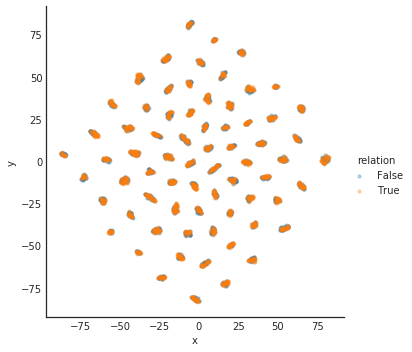

In [4]:
msgs, npzs = load_continuous_messages('data/500_400-end2end-gru-continuous64-30epochs-msgs.npz',
                                       proj='tsne', return_orig=True)
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='relation')

44 out of 64 dimensions are ever nonzero


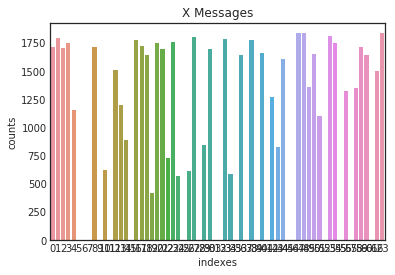

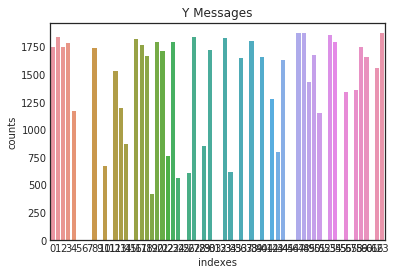

In [5]:
_ = plot_dimension_histograms(npzs)

In [6]:
_ = classify_relations_from_msgs(npzs, model=sklearn.svm.SVC)

2784 train, 928 test
Accuracy on test split: 0.4709051724137931


### Asymmetric Game, Continuous

Exact accuracy: 0.8116629464285714


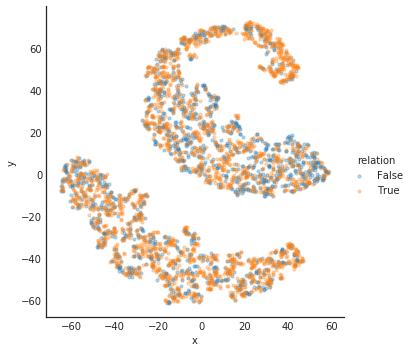

In [7]:
msgs = load_continuous_messages('data/500_500_asymTrue-end2end-gru-continuous64-30epochs-msgs.npz',
                               proj='tsne')
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='relation')

Exact accuracy: 0.8116629464285714


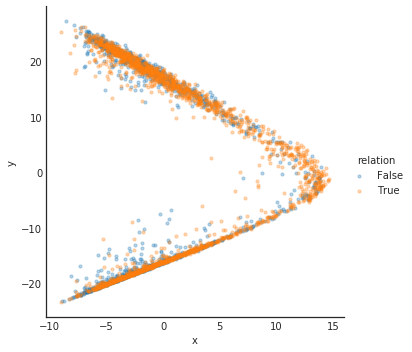

In [8]:
msgs, npzs = load_continuous_messages('data/500_500_asymTrue-end2end-gru-continuous64-30epochs-msgs.npz',
                               proj='pca', return_orig=True)
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='relation')

32 out of 64 dimensions are ever nonzero


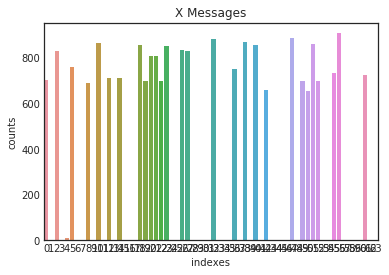

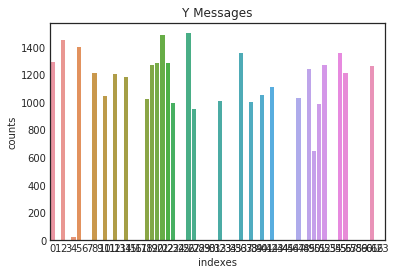

In [9]:
_ = plot_dimension_histograms(npzs)

In [10]:
_ = classify_relations_from_msgs(npzs, model=sklearn.svm.SVC)

2688 train, 896 test
Accuracy on test split: 0.6361607142857143


However, this isn't too interesting - we want to explore structure emerging from end-to-end models which have to process raw image data.